In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
# from warnings import catch_warnings, filterwarnings
# import tqdm

# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from pylab import rcParams

import xgboost as xgb
from fbprophet import Prophet

In [2]:
train_x = pd.read_csv("train_x.csv", parse_dates = ['timestamp'])
train_y = pd.read_csv("train_y.csv")

test_x = pd.read_csv("test_x.csv", parse_dates = ['timestamp'])
test_y = pd.read_csv("test_y.csv")

In [3]:
def train_test_split(data, percent_in_test):
    # splits data set into two arrays - train and test, based on the % to keep in test set
    num_to_test = len(data) - (round(len(data) * (percent_in_test / 100))) # convert % to float

    train = data[:num_to_test]
    test = data[num_to_test:]
    
    return train, test

In [4]:
train_x, eval_x = train_test_split(train_x, 15)
train_y, eval_y = train_test_split(train_y, 15)

In [5]:
train_x.head(1)

,timestamp,temperature,temperature_feel,humidity,wind_speed,weather_code,holiday_flag,weekend_flag,season
0,2015-01-04,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0


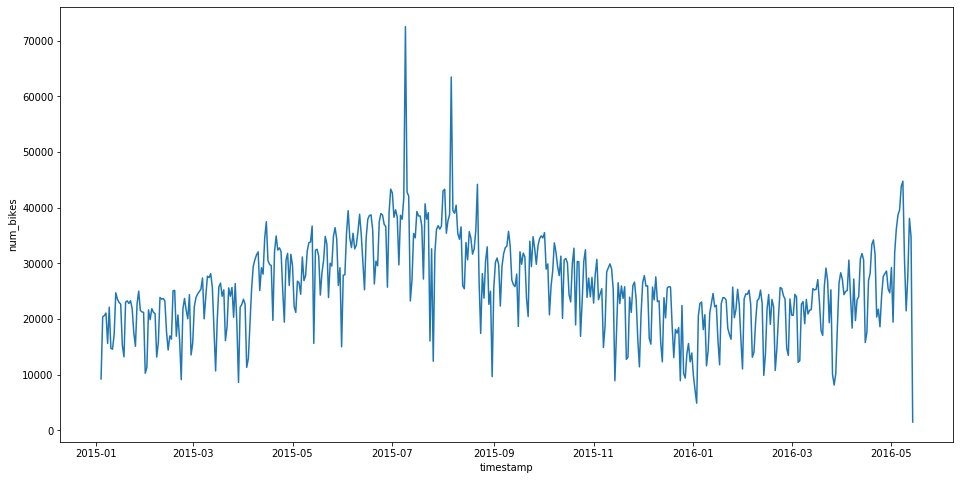

In [7]:
# group sales into daily view, so we get a neater view of trend
grouped_bikes = train_x[['timestamp']].copy() 
grouped_bikes['num_bikes'] = train_y['num_bikes'].copy()
grouped_bikes = pd.DataFrame(grouped_bikes.groupby(grouped_bikes['timestamp'].dt.date)['num_bikes'].sum())

# lineplot shows a bit of variance, the peaks will likely be weekends
plt.figure(figsize = (16,8))
sns.lineplot(x = grouped_bikes.index,
             y = grouped_bikes['num_bikes']);

### XGBoost

In [ ]:
# xgboost (eXtreme Gradient Boosting) is an ensembling model, with gradient boosting. It is both fast and reliable.
# gradient boosting means that new models are created that predict the residuals of prior models.

In [8]:
# xgboost doesn't like datetime datatypes, so we'll pull all the components out into new columns
def create_date_components(dataframe):
    
    dataframe['hour'] = dataframe['timestamp'].dt.hour
    dataframe['dayofweek'] = dataframe['timestamp'].dt.dayofweek
    dataframe['quarter'] = dataframe['timestamp'].dt.quarter
    dataframe['month'] = dataframe['timestamp'].dt.month
    dataframe['year'] = dataframe['timestamp'].dt.year
    dataframe['dayofyear'] = dataframe['timestamp'].dt.dayofyear
    dataframe['dayofmonth'] = dataframe['timestamp'].dt.day
    dataframe['weekofyear'] = dataframe['timestamp'].dt.weekofyear
    
    dataframe = dataframe.set_index('timestamp')
    
    return dataframe

In [9]:
xgboost_train_x = create_date_components(train_x.copy()) # has to be .copy() so we don't add columns inplace
xgboost_eval_x = create_date_components(eval_x.copy())

In [10]:
# instantiate model
reg = xgb.XGBRegressor(n_estimators=1000, 
                       max_depth = 10, 
                       learning_rate = 0.01,
                       eval_metric = 'rmse',
                       gamma = 2,
                       objective = 'reg:squarederror', 
                       random_state = 42)
reg.fit(xgboost_train_x, train_y, verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=2, importance_type='gain', learning_rate=0.01,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=1000, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [14]:
# max_depth = 10
preds = reg.predict(xgboost_eval_x) # make predictions
xgboost_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance

print(f"xgboost RMSE is {round(xgboost_result, 2)}")

xgboost RMSE is 278.46


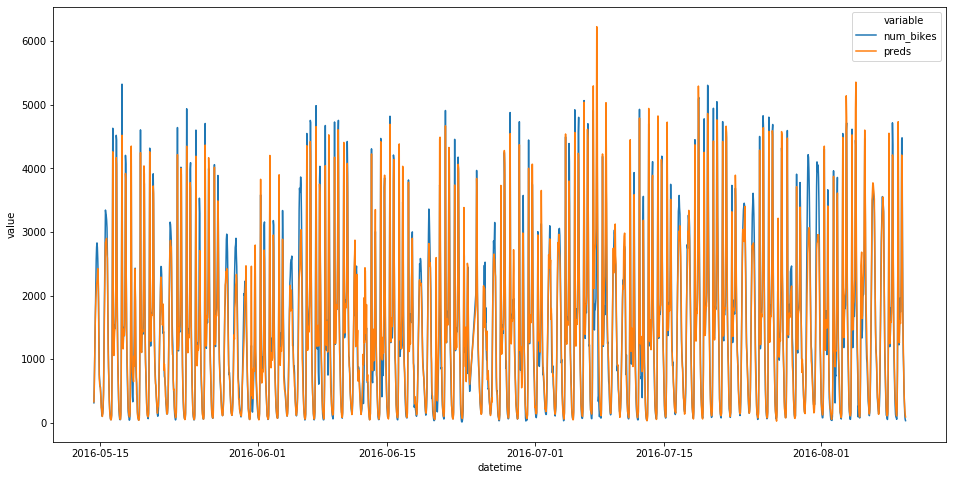

In [19]:
# create dataframe to plot
xgboost_plot = eval_y.copy()
xgboost_plot['datetime'] = eval_x['timestamp'].copy()
xgboost_plot['preds'] = preds
xgboost_plot = xgboost_plot.melt(value_vars = ['num_bikes', 'preds'], id_vars = 'datetime')

# show visualisation
plt.figure(figsize = (16,8))
sns.lineplot(x = xgboost_plot['datetime'], y = xgboost_plot['value'], hue = xgboost_plot['variable'])

### Prophet

In [ ]:
# Prophet is facebook's forecasting algorithm, and is used internally a lot. It is extremely powerful, and simple to implement

In [96]:
mod = Prophet(
              yearly_seasonality=True,
              seasonality_prior_scale=2,
              n_changepoints=10,
              weekly_seasonality = True,
              daily_seasonality = True,
              seasonality_mode='multiplicative'
        )

In [97]:
# prophet has a slightly different way of adding regressors - they can't just be supplied unexpectedly
additional_regressors = ['temperature', 'temperature_feel', 'humidity','wind_speed', 'weather_code', 'holiday_flag', 
                         'weekend_flag', 'season']

for regressor in additional_regressors:
    mod.add_regressor(regressor)

In [98]:
# the algorithm also expects your date and outcome variables to be named specifically
def column_renamer(dataset):
    dataset = dataset.rename({'timestamp':'ds','num_bikes':'y'}, axis = 1)
    return dataset

In [99]:
train = train_x.merge(train_y, left_index = True, right_index = True)
train = column_renamer(train)

In [100]:
mod.fit(train)

In [101]:
eval_x = column_renamer(eval_x)

In [102]:
preds = mod.predict(eval_x)['yhat']

In [103]:
prophet_result = sqrt(mean_squared_error(eval_y, preds)) # evaluate performance

print(f"prophet RMSE is {round(prophet_result, 2)}")

prophet RMSE is 707.43
